# UTILS:

In [ ]:
! pip install pypdf langchain sentence-transformers chromadb openai umap-learn -q

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

In [ ]:
import umap
import numpy as np
from tqdm import tqdm

from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

In [ ]:
from pypdf import PdfReader
from langchain.text_splitter import RecursiveCharacterTextSplitter, SentenceTransformersTokenTextSplitter
import chromadb
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction


def load_chroma(pdf_file, collection_name, embedding_function):

    reader = PdfReader(pdf_file)
    pdf_texts = [p.extract_text().strip() for p in reader.pages]

    character_splitter = RecursiveCharacterTextSplitter(
        separators=["\n\n", "\n", ". ", " ", ""],
        chunk_size=1000,
        chunk_overlap=0
    )

    character_split_texts = character_splitter.split_text('\n\n'.join(pdf_texts))


    token_splitter = SentenceTransformersTokenTextSplitter(chunk_overlap=0, tokens_per_chunk=256)

    token_split_texts = []
    for text in character_split_texts:
        token_split_texts += token_splitter.split_text(text)

    chroma_client = chromadb.Client() # Default chroma client
    chroma_collection = chroma_client.create_collection(collection_name,
                                                        embedding_function=embedding_function)

    ids = [str(i) for i in range(len(token_split_texts))] # ids for each txt chunk
    chroma_collection.add(ids=ids, documents=token_split_texts)

    return chroma_collection

In [ ]:
def project_embeddings(embeddings, umap_transform):
    umap_embeddings = np.empty((len(embeddings),2))
    for i, embedding in enumerate(tqdm(embeddings)):
        umap_embeddings[i] = umap_transform.transform([embedding])
    return umap_embeddings

# 1. INSTANTIATE LLM:

In [ ]:
import os
from google.colab import userdata
from openai import OpenAI

os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')
os.environ["HUGGINGFACE_API_KEY"] = userdata.get('HF_TOKEN')

openai_client = OpenAI()

# 2. CREATE CHROMA DB:

In [ ]:
data_path = 'drive/My Drive/DATA/advanced_RAG/'

In [ ]:
embedding_function = SentenceTransformerEmbeddingFunction()

chroma_collection = load_chroma(data_path +'microsoft_annual_report_2022.pdf',
                                collection_name='microsoft_annual_report_2022',
                                embedding_function=embedding_function)
chroma_collection.count()

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

349

# 3. DIM REDUCTION OF TXT TO 2D SPACE:

In [ ]:
embeddings = chroma_collection.get(include=['embeddings'])['embeddings']
umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit(embeddings)

projected_dataset_embeddings = project_embeddings(embeddings, umap_transform)

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
100%|██████████| 349/349 [06:57<00:00,  1.19s/it]


#4. CREATING A DATASET:

In [ ]:
def generate_queries(model="gpt-3.5-turbo"):
    messages = [
        {
            "role": "system",
            "content": "You are a helpful expert financial research assistant. \
            You help users analyze financial statements to better understand companies. "
            "Suggest 10 to 15 short questions that are important to ask when analyzing an annual report. "
            "Do not output any compound questions (questions with multiple sentences or conjunctions)."
            "Output each question on a separate line divided by a newline."
        },
    ]

    response = openai_client.chat.completions.create(
        model=model,
        messages=messages,
    )
    content = response.choices[0].message.content
    content = content.split("\n")
    return content

### a. GENERATED QUERIES:

In [ ]:
generated_queries = generate_queries()

for query in generated_queries:
    pprint(query)

"1. What are the company's total revenues for the year?"
"2. What is the company's net income?"
'3. How much does the company have in cash and cash equivalents?'
"4. What is the company's debt-to-equity ratio?"
'5. How much does the company spend on research and development?'
"6. What is the company's operating margin?"
"7. What is the company's current ratio?"
'8. How much does the company have in inventory?'
"9. What is the company's earnings per share?"
("10. How have the company's sales grown or declined compared to the previous "
 'year?')
"11. What is the company's return on assets?"
'12. How much does the company allocate to dividends?'
"13. What is the company's inventory turnover ratio?"
'14. How much does the company have in long-term investments?'
"15. What is the company's free cash flow?"


### b. RETREIVED DOCS:

In [ ]:
results = chroma_collection.query(query_texts=generated_queries,
                                  n_results=10, include=['documents', 'embeddings'])

retrieved_documents = results['documents']

In [ ]:
len(retrieved_documents)

15

In [ ]:
for doc in retrieved_documents[:2]:
    perc = int(len(doc) * 0.25)
    pprint(doc[:perc])
    print()
    print('-----------------------------------------------------------')

['revenue, classified by significant product and service offerings, was as '
 'follows : ( in millions ) year ended june 30, 2022 2021 2020 server products '
 'and cloud services $ 67, 321 $ 52, 589 $ 41, 379 office products and cloud '
 'services 44, 862 39, 872 35, 316 windows 24, 761 22, 488 21, 510 gaming 16, '
 '230 15, 370 11, 575 linkedin 13, 816 10, 289 8, 077 search and news '
 'advertising 11, 591 9, 267 8, 524 enterprise services 7, 407 6, 943 6, 409 '
 'devices 6, 991 6, 791 6, 457 other 5, 291 4, 479 3, 768 total $ 198, 270 $ '
 '168, 088 $ 143, 015 we have recast certain previously reported amounts in '
 'the table above to conform to the way we internally manage and monitor our '
 'business.',
 'that are not sold separately. • we tested the mathematical accuracy of '
 'management ’ s calculations of revenue and the associated timing of revenue '
 'recognized in the financial statements.']

-----------------------------------------------------------
['net income $ 72, 738

### c. CREATE LABELS (RELEVANCE - Y/N) FOR EACH RETRIEVED DOC:

In [ ]:
def f_create_label(query, statement, model="gpt-3.5-turbo"):
    messages = [
    {
        "role": "system",
        "content": "You are a helpful expert financial research assistant. You help users analyze financial statements to better understand companies. "
        "For the given query, evaluate whether the following satement is relevant."
        "Output only 'yes' or 'no'."
    },
    {
        "role": "user",
        "content": f"Query: {query}, Statement: {statement}"
    }
    ]

    response = openai_client.chat.completions.create(
        model=model,
        messages=messages,
        max_tokens=1
    )
    content = response.choices[0].message.content
    if content == "yes":
        return 1
    return -1

### d. DATASET INPUTS (QUERY - RETRIEVED DOCS PAIRS) & CORRESPONDING LABELS:

In [ ]:
retrieved_embeddings = results['embeddings']
query_embeddings = embedding_function(generated_queries)

adapter_query_embeddings = []
adapter_doc_embeddings = []
adapter_labels = []

for q, query in enumerate(tqdm(generated_queries)):
    for d, document in enumerate(retrieved_documents[q]):

        adapter_query_embeddings.append(query_embeddings[q])
        adapter_doc_embeddings.append(retrieved_embeddings[q][d])

        label = f_create_label(query, document)
        adapter_labels.append(label)

len(adapter_labels)

100%|██████████| 15/15 [00:56<00:00,  3.76s/it]


150

### e. CREATE TORCH DATASET:

In [ ]:
adapter_query_embeddings = torch.Tensor(np.array(adapter_query_embeddings))
adapter_doc_embeddings = torch.Tensor(np.array(adapter_doc_embeddings))
adapter_labels = torch.Tensor(np.expand_dims(np.array(adapter_labels),1))

dataset = torch.utils.data.TensorDataset(adapter_query_embeddings, adapter_doc_embeddings, adapter_labels)

In [ ]:
for i in dataset[:5]:
    print([j.shape for j in i])

[torch.Size([384]), torch.Size([384]), torch.Size([384]), torch.Size([384]), torch.Size([384])]
[torch.Size([384]), torch.Size([384]), torch.Size([384]), torch.Size([384]), torch.Size([384])]
[torch.Size([1]), torch.Size([1]), torch.Size([1]), torch.Size([1]), torch.Size([1])]


### f. LEARNING A WT MATRIX "W" TO MODIFY ORIGINAL QUERY ENCODING:
(SUCH THAT THEY ARE CLOSER TO RELEVANT DOCUMENTS IN THE EMBEDDING SPACE)

In [ ]:
def model(query_embedding, document_embedding, adaptor_matrix):
    updated_query_embedding = torch.matmul(adaptor_matrix, query_embedding)
    return torch.cosine_similarity(updated_query_embedding, document_embedding, dim=0)

In [ ]:
def mse_loss(query_embedding, document_embedding, adaptor_matrix, label):
    pred = model(query_embedding, document_embedding, adaptor_matrix)
    return torch.nn.MSELoss()(pred, label)

In [ ]:
# Initialize the adaptor matrix
mat_size = len(adapter_query_embeddings[0])
adapter_matrix = torch.randn(mat_size, mat_size, requires_grad=True)

TRAINING:

In [ ]:
min_loss = float('inf')
best_matrix = None

for epoch in tqdm(range(100)):
    for query_embedding, document_embedding, label in dataset:
        loss = mse_loss(query_embedding, document_embedding, adapter_matrix, label)

        if loss < min_loss:
            min_loss = loss
            best_matrix = adapter_matrix.clone().detach().numpy()

        loss.backward()
        with torch.no_grad():
            adapter_matrix -= 0.01 * adapter_matrix.grad
            adapter_matrix.grad.zero_()


  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


In [ ]:
print(f"Best loss: {scaled_vector.flatten().detach().numpy()}")

Best loss: 0.45653483271598816


### g. COMPARE ORIGINAL & MODIFIED QUERY EMBEDDINGS:

In [ ]:
np.array(query_embeddings).shape, best_matrix.shape

((15, 384), (384, 384))

In [ ]:
query_embeddings = embedding_function(generated_queries)
adapted_query_embeddings = np.array(query_embeddings) @ best_matrix

projected_query_embeddings = project_embeddings(query_embeddings, umap_transform)
projected_adapted_query_embeddings = project_embeddings(adapted_query_embeddings, umap_transform)

100%|██████████| 15/15 [00:19<00:00,  1.29s/it]


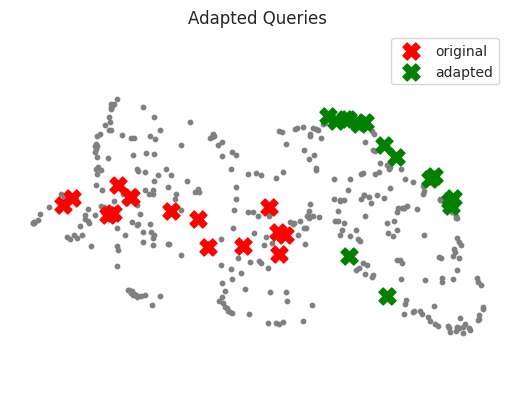

In [ ]:
# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0],
            projected_dataset_embeddings[:, 1],
            s=10, color='gray')

plt.scatter(projected_query_embeddings[:, 0],
            projected_query_embeddings[:, 1],
            s=150, marker='X', color='r',
            label="original")

plt.scatter(projected_adapted_query_embeddings[:, 0],
            projected_adapted_query_embeddings[:, 1],
            s=150, marker='X', color='green',
            label="adapted")

plt.gca().set_aspect('equal', 'datalim')
plt.title("Adapted Queries")
plt.axis('off')
plt.legend()